### Imports and config

In [1]:
# Libraries
import os
from importlib import reload
import keras

# Scripts
from helpers import data, runners, utils

In [2]:
# Should be v2.10
!pip show tensorflow 

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
# Should be v2.10
!pip show keras 

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(data)
reload(runners)
reload(utils)

<module 'helpers.utils' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\utils.py'>

In [5]:
# Silence information messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 


GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

In [6]:
NUM_FOLDS = 10
NUM_EPOCHS = 5
GPU_BATCH_SIZE = 16
DATA_BATCH_SIZE = 16

### Load data

In [7]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv='../data/DATASET_CSVS/deepship_5k_seg_3s.csv',
    new_path_to_root='../data/deepship_baseline_unnorm_mat',
    ext='mat',
    unix=False,
    label_encodings={0:'Tanker', 1:'Cargo', 2:'Tug', 3:'Passengership'},
    n_folds=NUM_FOLDS
)
print('Successfully loaded folds.\n')

Successfully loaded folds.



In [8]:
total_samples = 0
for fold_df in fold_dfs:
    total_samples += len(fold_df)
print(total_samples)

53502


### Initialise and configure model

In [9]:
def get_compiled_model():
    """
    The caller should write this function to return a compiled
    `keras.Model` object to be fed into the k-fold cross validation script.
    """

    from models import cnn_lstm

    cnn_lstm_model = cnn_lstm.get_cnn_lstm(
        input_shape=(192, 192, 1),
        input_name='spec',
        num_classes=4,
        verbose=False
    )

    cnn_lstm_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['acc']
    )

    return cnn_lstm_model

In [10]:
# These are kwargs for Model.fit() and Model.evaluate() excluding x and y.
fit_kwargs = {
    'epochs': NUM_EPOCHS,
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1
}

eval_kwargs = {
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1
}

### Run k-fold cross val

In [11]:
reload(runners)

# [DBS = GBS = 8] 5 folds, 3 epochs = 100 - 160 min
# [DBS = GBS = 16] 5 folds, 3 epochs = 80 - 100 min
# [DBS = GBS = 16] 5 folds, 3 epochs = 340 min
# [DBS = GBS = 16] 10 folds, 3 epochs = 450 - 500 min

model, histories, evals, metrics = runners.k_fold_cross_validation(
    fold_dfs=fold_dfs,
    model_builder=get_compiled_model,
    fit_kwargs=fit_kwargs,
    eval_kwargs=eval_kwargs,
    ext="mat",
    mat_var_name="Ptrans",
    data_batch_size=DATA_BATCH_SIZE,
    use_cpu=False
)

FOLD 1/10
Epoch 1/5
2716/2716 [==============================] - 491s 178ms/step - loss: 0.7758 - acc: 0.6901 - val_loss: 0.7461 - val_acc: 0.7004
Epoch 2/5
2716/2716 [==============================] - 609s 224ms/step - loss: 0.4737 - acc: 0.8249 - val_loss: 0.7803 - val_acc: 0.6771
Epoch 3/5
2716/2716 [==============================] - 825s 304ms/step - loss: 0.3187 - acc: 0.8924 - val_loss: 0.7989 - val_acc: 0.6596
Epoch 4/5
2716/2716 [==============================] - 1008s 371ms/step - loss: 0.2154 - acc: 0.9329 - val_loss: 0.8247 - val_acc: 0.6549
Epoch 5/5
1/1 [==============================] - 0s 18ms/step
FOLD 2/10
Epoch 1/5
2666/2666 [==============================] - 956s 358ms/step - loss: 0.7799 - acc: 0.6857 - val_loss: 0.9076 - val_acc: 0.6575
Epoch 2/5
2666/2666 [==============================] - 938s 352ms/step - loss: 0.4759 - acc: 0.8241 - val_loss: 0.9540 - val_acc: 0.6704
Epoch 3/5
2666/2666 [==============================] - 820s 308ms/step - loss: 0.3185 - acc: 0.

In [12]:
model.save('models/saved/new_cnn_lstm.keras')

### Calculate metrics

In [13]:
evals

[[0.8794556856155396, 0.6897084712982178],
 [0.824497401714325, 0.7020772695541382],
 [1.0255334377288818, 0.6775525808334351],
 [1.3513129949569702, 0.5754668116569519],
 [1.340958595275879, 0.6021005511283875],
 [1.274325966835022, 0.6267170310020447],
 [1.516797423362732, 0.5488528609275818],
 [1.102840781211853, 0.6399999856948853],
 [1.3990527391433716, 0.578125],
 [0.8985965847969055, 0.7005681991577148]]

In [14]:
loss, acc = utils.calculate_metrics(evals)
print(f"Average loss: {loss}")
print(f"Average accuracy: {acc}")

Average loss: 1.1613371610641479
Average accuracy: 0.6341168761253357


C:\Users\sonar\AppData\Local\Temp\ipykernel_15316\1612418249.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


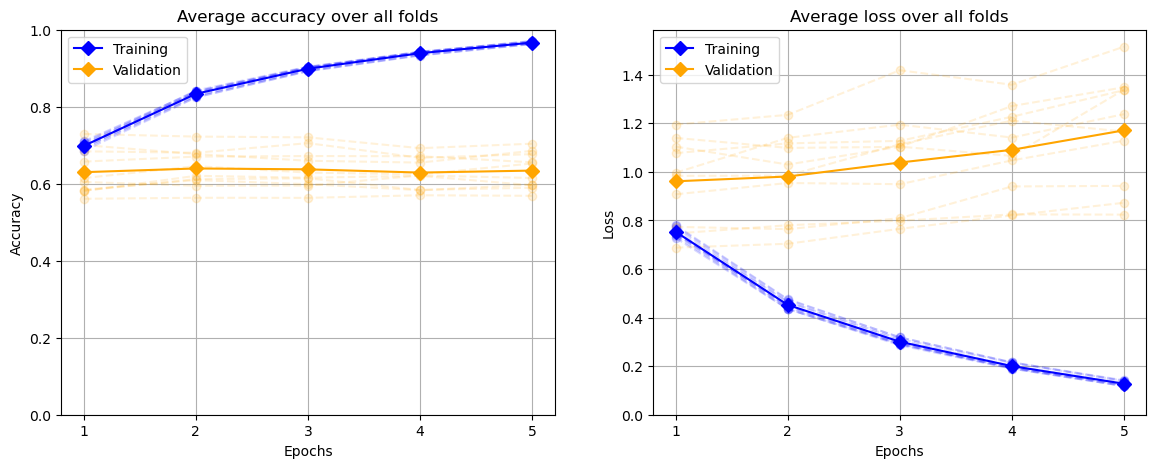

In [18]:
reload(utils)

fig = utils.get_acc_loss_curves_by_epoch(histories, overlay=True)
fig.savefig('models/saved/new_cnn_lstm_3_epochs_by_epoch.pdf')
fig.show()

C:\Users\sonar\AppData\Local\Temp\ipykernel_15316\636994058.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


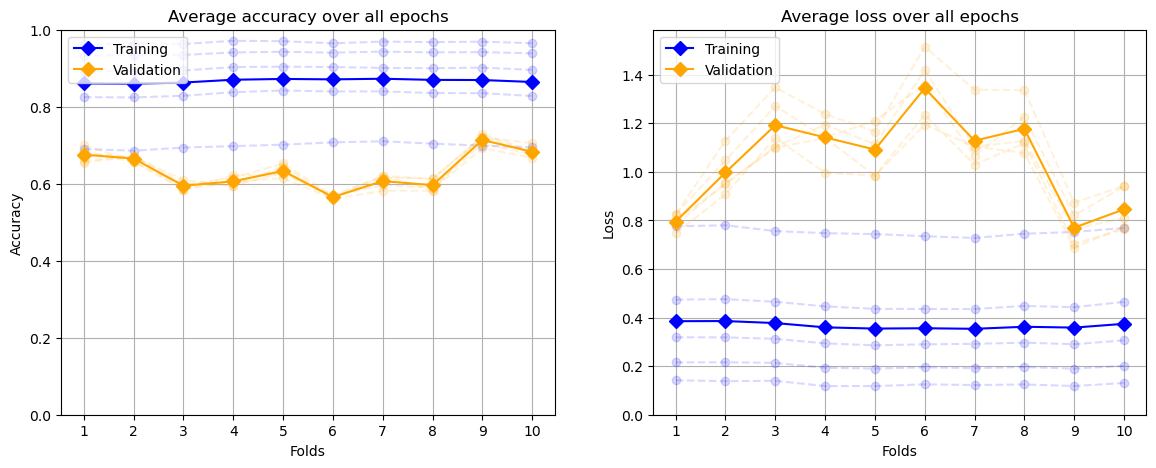

In [19]:
reload(utils)

fig = utils.get_acc_loss_curves_by_fold(histories, overlay=True)
fig.savefig('models/saved/new_cnn_lstm_3_epochs_by_fold.pdf')
fig.show()

In [17]:
print("Average Precision:", metrics["precision"])
print("Average Recall:", metrics["recall"])
print("Average F1 Score:", metrics["f1_score"])
print("Average Accuracy:", metrics["accuracy"])

Average Precision: 0.6653129955004038
Average Recall: 0.6341168711423063
Average F1 Score: 0.6374502020411382
Average Accuracy: 0.6341168711423063
